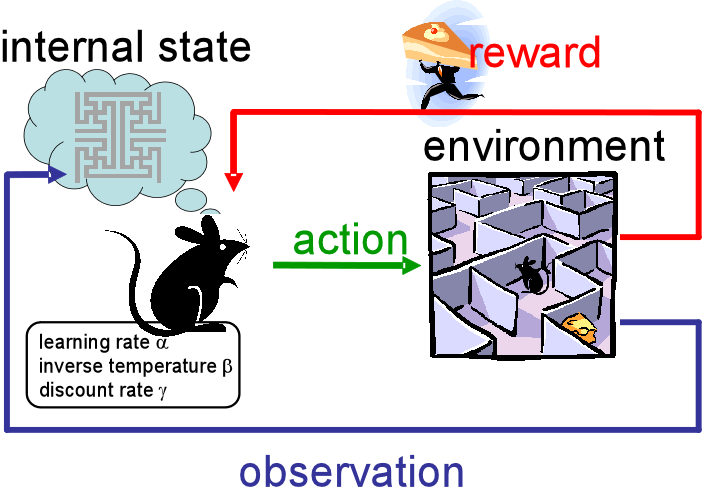

# Genetic Algorithm
*  Mostly used in optimization and search problems
* Can be used also in fun ways like games or simulators

## How it's done
* 1) Initialize a starting population. This will serve as the first genreation. Usually generated at random
* 2) Apply a fitness function on the current generation. This is a function that will say how good each individual performs
* 3) Select a small percent of the best individuals to pass unchanged to the next genration.  This is caled Elitism
* 4) Combine the genes of two randomly selected 'parents' . Do this untill the next generation is full. This is called crossover
* 5) Randomly modify genes of some individuals. This is called mutation
* 6) Go back to step 2 untill you are satisfied by the score

## Drawbacks
* Slow fitness function
* The 'best' is not usually defined 
* Don't do so good on big problems
* Early convergence on a suboptimal path

### Useful links 
* https://towardsdatascience.com/introduction-to-optimization-with-genetic-algorithm-2f5001d9964b
* https://gym.openai.com/
* https://heartbeat.fritz.ai/reproducing-images-using-a-genetic-algorithm-with-python-91fc701ff84
* https://en.wikipedia.org/wiki/Evolved_antenna
* https://www.youtube.com/watch?v=qv6UVOQ0F44&t=131s

# Traveling Salesman

In [31]:
import numpy as np
import random
from PIL import Image, ImageDraw
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

In [32]:
#parameters fixing

r = 7 # # This is only used for the drawings
im_size = 512 # This is only used for the drawings

city_nr = 25 # The number of cities the salesman has to visit
gen_size = 500 # How many individuals are in a generation
keep = 30 # The number of individuals directly passed to the next genertion (Elitism)

next_gen = 250 # Only the first next_gen individuals will be used for crossover
regenerate = gen_size - keep # We will need to generate this many individuals from the crossover

mutations = 400 # How many mutation we want. Note that the same individual can be mutated twice

gen_flat_line = 200 # We stop when nothing better was found after this many generations

In [33]:
#City Building
cities = np.random.randint(0, 512, (city_nr, 2)) # We generate of coordinates [x, y]


dist_mat = np.zeros((city_nr, city_nr)) # In order to make the fitness faster, we pregenerate the distance matrix
for i in range(1, city_nr):
    for j in range(i+1, city_nr):
        dist = np.linalg.norm(cities[i]-cities[j])
        dist_mat[i][j] = dist
        dist_mat[j][i] = dist

In [34]:
#Generation
population = np.asarray([np.random.permutation(city_nr) for _ in range(gen_size)]) 
#Because each city will be visited only once, an individual is a random permutation 

In [35]:
#this function is used for drawing
def draw(cits, elem):
    al = list(elem)
    al.append(al[0])
    image = Image.new('RGB', (im_size, im_size))
    draw = ImageDraw.Draw(image)
    for el in cits:
        x, y = el[0], el[1]
        draw.ellipse((x-r, y-r, x+r, y+r), fill=(255,0,0,0))
    line = [tuple(el) for el in cits[al]]
    draw.line(line, fill=(0,255,255,0), width=5)
    display(image)

In [36]:
m1 = np.full(city_nr, -1) # we use this array to select genes from an individual
#Because we can't use the same city twice, a formula like child[i] = random_between(parent_1[i], parent_2[i]) can't be used
#Instead we will drop gens from one parrent and use the ordered genes from the other to fill the gaps, always checking for duplicates

def cross(a, b):
    c = np.random.randint(0, 2, (city_nr), dtype='bool')
    d = np.where(c, a, m1)
    j = 0
    for i in range(len(d)):
        if d[i] == -1:
            while b[j] in d:
                j += 1
            d[i] = b[j]
    return d

In [37]:
#used for plotting at the end, and stoping 
solutions = [] 
generations = []
same_score = 0
old_score = 0

2053.7994352920396


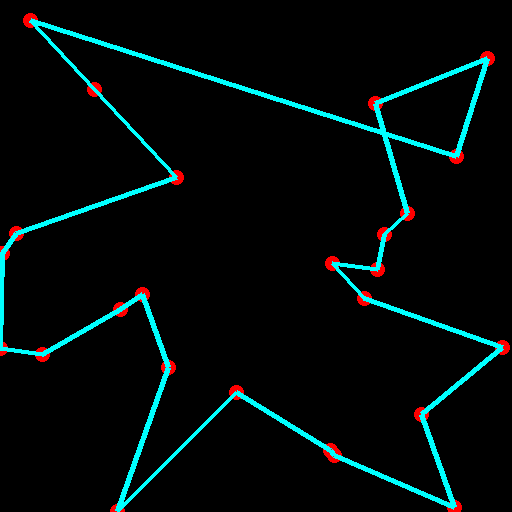

In [38]:
while True:
    
    generations.append(population.copy()) #used for plotting at the end
    
    # Fitness cheking, we compute the distances between every city in an individual, for the whole population
    scores = np.asarray([np.sum(dist_mat[el, np.roll(el, shift=-1)])  for el in population]) 
    
    # We sort the scores, the lower the better (we have to optimize the distance)
    args = np.argsort(scores, axis = 0) # we take the sorted indexes to make it easy
    args = args.flatten()
    
    # We only need the individuals that will be part of crossover, so we can drop the rest
    population = population[args[:next_gen]] 
    scores = scores[args[:next_gen]]
    
    
    # This part is used to stop the model and print results for each best
    if same_score == gen_flat_line:
        break 
        
    if scores[0] != old_score:
        clear_output()
        print(scores[0])
        draw(cities, population[0])
        same_score = 0
    else:
        same_score += 1
    old_score = scores[0]
    solutions.append(old_score)
    
    
    
    # When we pick the parents, we try to pick the ones with better score more
    # so we make an probabilty array starting from the score
    
    sm = np.sum(scores)
    probs = np.array([el / sm for el in scores])[::-1]
    rindex = np.random.choice(next_gen, (regenerate, 2), p=probs)
    
    #     rindex = np.random.randint(0, next_gen, (regenerate, 2)) # uncomment this if u don't want to use the score
    
    ls = [cross(population[el[0]], population[el[1]]) for el in rindex] #crossover
    x = np.asarray(ls)
    
    population = population[:keep] # We drop everythin from the old generation, except the elites 
    population = np.append(population, x, axis=0) # And put the new generation instead

    
    
    r_indexes = np.random.randint(keep, gen_size, (mutations)) # Selecting the individuals for mutations.
                                                               # Note that we don't mutate the elites
    r_city = np.random.randint(0, city_nr, (mutations, 2))     # Selecting the cities to be swaped 

    # Doing the mutation
    for i, el in enumerate(r_city):
        population[r_indexes[i]][el[0]], population[r_indexes[i]][el[1]] = population[r_indexes[i]][el[1]], population[r_indexes[i]][el[0]]
    

In [39]:
plt.close()
plt.plot(solutions)

<IPython.core.display.Javascript object>

In [44]:
from matplotlib import animation

plt.rcParams['animation.html'] = 'html5'

lines = []
plt.ioff()
fig = plt.figure(figsize=(9, 9))
plt.scatter(*cities.T)
for path in generations[0]:
    path = [*path, path[0]]
    lines.append(plt.plot(cities.T[0][path], cities.T[1][path], alpha=.01, c='k')[0])
    
def animate(i):
    global lines
    for line, path in zip(lines, generations[i]):
        path = [*path, path[0]]
        line.set_data(cities.T[0][path], cities.T[1][path])
        
    return (lines, )

anim = animation.FuncAnimation(fig, animate, frames=range(0, len(generations), 10), interval=100, blit=True, repeat_delay=1500)
plt.ion()
anim